In [1]:
!pip install torch torchvision pytorch-lightning scikit-learn pandas pillow matplotlib seaborn

  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 29.7 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 29.2 MB/s  0:00:00
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.1 MB/s  0:00:00
Using c

In [1]:
# %% Cell 1 — Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models
from PIL import Image

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

print("Imports done. PyTorch:", torch.__version__, "Lightning:", pl.__version__)

Imports done. PyTorch: 2.8.0 Lightning: 2.5.5


In [2]:
# %% Cell 2 — CONFIG: edit paths and training hyperparameters
# Update these paths to match your local filesystem
CSV_PATH = "./fake_job_postings.csv"   # optional: CSV with metadata (not required)
IMAGE_ROOT = "./images"                # must contain subfolders '0' and '1'
TARGET_COL = "label"                   # name to use in df_img (we'll set 0/1 based on folder)
RANDOM_STATE = 42

# Model / training config
BACKBONE = "mobilenet_v2"   # "mobilenet_v2", "resnet18", "resnet50"
PRETRAINED = True
BATCH_SIZE = 32
IMG_SIZE = 224
LR = 1e-4
MAX_EPOCHS = 8
NUM_WORKERS = 4
OUT_DIR = "./image_models"
os.makedirs(OUT_DIR, exist_ok=True)

print("Config set. IMAGE_ROOT:", IMAGE_ROOT, "OUT_DIR:", OUT_DIR)

Config set. IMAGE_ROOT: ./images OUT_DIR: ./image_models


In [3]:
# %% Cell 3 — Build df_img from folder structure IMAGE_ROOT/0 and IMAGE_ROOT/1
# This cell ignores any image-path column in CSV and uses folders named '0' and '1' as labels.
if not os.path.exists(IMAGE_ROOT):
    raise FileNotFoundError(f"IMAGE_ROOT not found: {IMAGE_ROOT}")

subfolders = ["0", "1"]
found = {}
for s in subfolders:
    p = os.path.join(IMAGE_ROOT, s)
    found[s] = p if os.path.isdir(p) else None

if not any(found.values()):
    raise RuntimeError(f"No class subfolders found under {IMAGE_ROOT}. Expected subfolders: {subfolders}")

rows = []
image_exts = [".png", ".jpg", ".jpeg", ".webp", ".bmp"]
for label_str, folder in found.items():
    if folder is None:
        continue
    # recursive glob for image files
    files = []
    for ext in image_exts:
        files.extend(glob(os.path.join(folder, f"**/*{ext}"), recursive=True))
    files = sorted(files)
    for fp in files:
        rows.append({"_img_path": fp, TARGET_COL: int(label_str)})

df_img = pd.DataFrame(rows)
if df_img.empty:
    raise RuntimeError("No images found under the expected subfolders.")
print("Collected images per class:")
print(df_img[TARGET_COL].value_counts())
display(df_img.sample(min(len(df_img), 8), random_state=RANDOM_STATE).reset_index(drop=True))

Collected images per class:
label
0    16934
1      862
Name: count, dtype: int64


,_img_path,label
0,./images/0/9155.png,0
1,./images/0/13446.png,0
2,./images/0/5402.png,0
3,./images/0/2250.png,0
4,./images/0/16744.png,0
5,./images/0/8863.png,0
6,./images/0/3380.png,0
7,./images/0/13090.png,0


In [4]:
# %% Cell 4 — Optional: load CSV metadata if you want to merge (best-effort)
# If you have a CSV with metadata and want to join by image basename -> job id, uncomment and adjust below.
if os.path.exists(CSV_PATH):
    try:
        df_meta = pd.read_csv(CSV_PATH)
        print("Loaded CSV metadata:", CSV_PATH, "shape:", df_meta.shape)
        # best-effort: try to merge by basename <-> job_id if job_id exists
        # df_img['basename'] = df_img['_img_path'].apply(lambda p: Path(p).stem)
        # if 'job_id' in df_meta.columns:
        #     df_img = df_img.merge(df_meta, left_on='basename', right_on='job_id', how='left', suffixes=('','_meta'))
        #     print("Merged df_img with metadata by basename <-> job_id (if present).")
    except Exception as e:
        print("Could not load CSV (safe to ignore):", e)
else:
    print("CSV metadata not found at CSV_PATH (this is fine).")

Loaded CSV metadata: ./fake_job_postings.csv shape: (17880, 18)


In [5]:
# %% Cell 5 — Train/Val split (stratified)
if df_img.empty:
    raise RuntimeError("df_img is empty — ensure IMAGE_ROOT contains subfolders 0 and 1 with images.")
train_df, val_df = train_test_split(df_img, test_size=0.2, stratify=df_img[TARGET_COL], random_state=RANDOM_STATE)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print("Train / Val sizes:", len(train_df), len(val_df))

Train / Val sizes: 14236 3560


In [6]:
# %% Cell 6 — Dataset class and transforms
class JobImageDataset(Dataset):
    def __init__(self, df, image_col="_img_path", label_col=TARGET_COL, transform=None):
        self.df = df
        self.image_col = image_col
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row[self.image_col]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(row[self.label_col])
        return img, label

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = T.Compose([
    T.RandomResizedCrop(IMG_SIZE),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_transform = T.Compose([
    T.Resize(int(IMG_SIZE * 1.14)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std)
])
print("Transforms defined.")

Transforms defined.


In [7]:
# %% Cell 7 — Dataloaders
train_ds = JobImageDataset(train_df, image_col="_img_path", label_col=TARGET_COL, transform=train_transform)
val_ds   = JobImageDataset(val_df,   image_col="_img_path", label_col=TARGET_COL, transform=val_transform)

pin_mem = bool(torch.cuda.is_available())
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=pin_mem)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)

print("Dataloaders ready. Train batches:", len(train_loader), "Val batches:", len(val_loader))

Dataloaders ready. Train batches: 445 Val batches: 112


In [8]:
# %% Cell 8 — Backbone builder (swap models easily)
def build_backbone_classifier(backbone_name="mobilenet_v2", pretrained=True, num_classes=2):
    b = backbone_name.lower()
    if b == "mobilenet_v2":
        m = models.mobilenet_v2(pretrained=pretrained)
        in_features = m.classifier[-1].in_features
        m.classifier = nn.Sequential(nn.Dropout(p=0.3), nn.Linear(in_features, num_classes))
        return m
    if b == "resnet18":
        m = models.resnet18(pretrained=pretrained)
        in_features = m.fc.in_features
        m.fc = nn.Linear(in_features, num_classes)
        return m
    if b == "resnet50":
        m = models.resnet50(pretrained=pretrained)
        in_features = m.fc.in_features
        m.fc = nn.Linear(in_features, num_classes)
        return m
    raise ValueError(f"Backbone '{backbone_name}' not in template. Add branch to builder.")
print("Backbone builder ready.")

Backbone builder ready.


In [9]:
# %% Cell 9 — LightningModule (Lightning v2 compatible)
class ImageClassifierPL_v2(LightningModule):
    def __init__(self, backbone_name="mobilenet_v2", lr=1e-4, pretrained=True, num_classes=2, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = build_backbone_classifier(backbone_name, pretrained=pretrained, num_classes=num_classes)
        self.lr = lr
        if pos_weight is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=pos_weight)
        else:
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.loss_fn(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == labels).float().mean()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.loss_fn(logits, labels)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
        return {"val_loss": loss.detach().cpu(), "preds": preds.detach().cpu(), "probs": probs.detach().cpu(), "labels": labels.detach().cpu()}

    def on_validation_epoch_end(self):
        # robust aggregation: handle single or list val dataloaders
        val_loaders = getattr(self.trainer, "val_dataloaders", None)
        if val_loaders is None:
            try:
                val_loaders = self.trainer._data_connector._val_dataloader_source.dataloaders
            except Exception:
                val_loaders = None
        if val_loaders is None:
            return
        if isinstance(val_loaders, (list, tuple)):
            val_loader = val_loaders[0]
        else:
            val_loader = val_loaders

        all_preds, all_probs, all_labels = [], [], []
        device = self.device
        self.eval()
        with torch.no_grad():
            for batch in val_loader:
                imgs, labels = batch
                imgs = imgs.to(device)
                logits = self(imgs)
                probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
                preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
                all_probs.extend(probs.tolist())
                all_preds.extend(preds.tolist())
                all_labels.extend(labels.numpy().tolist())

        if len(all_labels) > 0:
            try:
                roc = roc_auc_score(all_labels, all_probs)
            except Exception:
                roc = float("nan")
            acc = (np.array(all_preds) == np.array(all_labels)).mean()
            self.log("val_acc", acc, prog_bar=True)
            self.log("val_roc_auc", roc, prog_bar=True)
            self.val_preds = np.array(all_preds)
            self.val_probs = np.array(all_probs)
            self.val_labels = np.array(all_labels)
        self.train()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_roc_auc"}}

print("Lightning module defined.")

Lightning module defined.


In [10]:
# %% Cell 10 — instantiate model, callbacks & Trainer (safe devices logic)
pl.seed_everything(RANDOM_STATE)

model_v2 = ImageClassifierPL_v2(backbone_name=BACKBONE, lr=LR, pretrained=PRETRAINED, num_classes=2)

checkpoint_cb = ModelCheckpoint(dirpath=OUT_DIR, filename="img-v2-{epoch:02d}-{val_roc_auc:.4f}", monitor="val_roc_auc", save_top_k=1, mode="max")
early_cb = EarlyStopping(monitor="val_roc_auc", patience=4, mode="max", verbose=True)
lrmon = LearningRateMonitor(logging_interval="epoch")

if torch.cuda.is_available():
    devices = 1
    accelerator = "gpu"
    precision = 16
else:
    devices = 1
    accelerator = "cpu"
    precision = 32

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator=accelerator,
    devices=devices,
    callbacks=[checkpoint_cb, early_cb, lrmon],
    log_every_n_steps=20,
    precision=precision,
)

print("Trainer created. Accelerator:", accelerator, "devices:", devices)
print("Checkpoint dir:", OUT_DIR)

Seed set to 42
/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/anaghah/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 36.9MB/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Trainer created. Accelerator: cpu devices: 1
Checkpoint dir: ./image_models


/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [15]:
# %% Cell 11 — train (optionally resume from last checkpoint)
resume = False   # set True to resume from last .ckpt in OUT_DIR
ckpt_to_use = None
if resume:
    ckpts = sorted([os.path.join(OUT_DIR, f) for f in os.listdir(OUT_DIR) if f.endswith(".ckpt")])
    if ckpts:
        ckpt_to_use = ckpts[-1]
        print("Resuming from checkpoint:", ckpt_to_use)

if ckpt_to_use:
    trainer.fit(model_v2, train_loader, val_loader, ckpt_path=ckpt_to_use)
else:
    trainer.fit(model_v2, train_loader, val_loader)

print("Training finished. Best checkpoint:", checkpoint_cb.best_model_path)


  | Name    | Type             | Params | Mode
----------------------------------------------------
0 | model   | MobileNetV2      | 2.2 M  | eval
1 | loss_fn | CrossEntropyLoss | 0      | eval
----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.906     Total estimated model params size (MB)
0         Modules in train mode
214       Modules in eval mode


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    exitcode = _main(fd, parent_sentinel)
  File "/o

RuntimeError: DataLoader worker (pid(s) 15411, 15412, 15413, 15414) exited unexpectedly

In [12]:
# quick test: run one batch on the main process (no multiprocessing)
test_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0, pin_memory=False)
for i, batch in enumerate(test_loader):
    imgs, labels = batch
    print("Batch", i, "imgs shape", imgs.shape, "labels", labels.shape)
    if i >= 2:
        break

Batch 0 imgs shape torch.Size([8, 3, 224, 224]) labels torch.Size([8])
Batch 1 imgs shape torch.Size([8, 3, 224, 224]) labels torch.Size([8])
Batch 2 imgs shape torch.Size([8, 3, 224, 224]) labels torch.Size([8])


In [13]:
from PIL import Image
bad = []
for i, p in enumerate(df_img["_img_path"]):
    try:
        with Image.open(p) as im:
            im.verify()   # verify reads header but may not fully decode
        # Optionally try to actually load (safer)
        # with Image.open(p) as im:
        #     im.convert("RGB")
    except Exception as e:
        bad.append((p, str(e)))
        if len(bad) <= 20:
            print("Bad:", p, "error:", e)
print("Total bad images found:", len(bad))

Total bad images found: 0


In [14]:
from torch.utils.data import DataLoader

class SafeJobImageDataset(JobImageDataset):
    def __getitem__(self, idx):
        try:
            return super().__getitem__(idx)
        except Exception as e:
            # log the failure for debugging (choose print or write to a list/file)
            print(f"Dataset __getitem__ error idx={idx}, path={self.df.iloc[idx][self.image_col]} -> {e}")
            # return a sentinel to be filtered by collate_fn
            return None

def collate_skip_none(batch):
    # filter out None samples
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None  # upstream will break; but unlikely if dataset large
    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return imgs, labels

# create safe loaders
safe_train_ds = SafeJobImageDataset(train_df, image_col="_img_path", label_col=TARGET_COL, transform=train_transform)
safe_val_ds = SafeJobImageDataset(val_df, image_col="_img_path", label_col=TARGET_COL, transform=val_transform)

train_loader = DataLoader(safe_train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=torch.cuda.is_available(), collate_fn=collate_skip_none)
val_loader = DataLoader(safe_val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, pin_memory=torch.cuda.is_available(), collate_fn=collate_skip_none)

In [16]:
# %% Quick test: run a few batches on the main process (no worker subprocesses)
# This reveals the real exception (if any) instead of a worker-exit message.
print("Running quick dataloader test with num_workers=0 (main process)...")
test_loader = DataLoader(train_ds, batch_size=min(8, BATCH_SIZE), shuffle=True, num_workers=0, pin_memory=False)
for i, batch in enumerate(test_loader):
    imgs, labels = batch
    print(f"Batch {i}: imgs {imgs.shape}, labels {labels.shape}")
    if i >= 2:
        break
print("Quick dataloader test completed (no worker processes).")

Running quick dataloader test with num_workers=0 (main process)...
Batch 0: imgs torch.Size([8, 3, 224, 224]), labels torch.Size([8])
Batch 1: imgs torch.Size([8, 3, 224, 224]), labels torch.Size([8])
Batch 2: imgs torch.Size([8, 3, 224, 224]), labels torch.Size([8])
Quick dataloader test completed (no worker processes).


In [17]:
# %% Scan all images for corruption/unopenable files (PIL verify)
# This will try to open and verify image headers; prints up to first 20 bad files and the total count.
from PIL import Image
bad = []
print("Scanning images for issues (this may take a while if many images)...")
for i, p in enumerate(df_img["_img_path"]):
    try:
        with Image.open(p) as im:
            im.verify()   # checks file integrity (does not fully decode)
    except Exception as e:
        bad.append((p, str(e)))
        if len(bad) <= 20:
            print("Bad image:", p, "error:", e)
print("Total bad images found:", len(bad))

# If any bad files found — optionally drop them
if len(bad) > 0:
    bad_paths = set(p for p, _ in bad)
    print("Dropping bad image rows from df_img (and rebuilding train/val split).")
    df_img = df_img[~df_img["_img_path"].isin(bad_paths)].reset_index(drop=True)
    # rebuild train/val
    from sklearn.model_selection import train_test_split
    train_df, val_df = train_test_split(df_img, test_size=0.2, stratify=df_img[TARGET_COL], random_state=RANDOM_STATE)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    print("New train/val sizes:", len(train_df), len(val_df))
else:
    print("No corrupted images detected (good).")

Scanning images for issues (this may take a while if many images)...
Total bad images found: 0
No corrupted images detected (good).


In [18]:
# %% Safe dataset + collate to skip failing samples at runtime
# Use this if you want training to continue even if some images crash when loaded.
import torch

class SafeJobImageDataset(JobImageDataset):
    def __getitem__(self, idx):
        try:
            return super().__getitem__(idx)
        except Exception as e:
            # print a small, useful message. If you're using multiple workers, this will appear in worker stdout.
            print(f"Safe dataset skip: idx={idx}, path={self.df.iloc[idx][self.image_col]} -> {e}")
            return None

def collate_skip_none(batch):
    # remove None samples
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        # return an empty batch (caller may error) — unlikely for large datasets
        return None
    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return imgs, labels

# Create safe datasets + dataloaders (uses NUM_WORKERS from config)
safe_train_ds = SafeJobImageDataset(train_df, image_col="_img_path", label_col=TARGET_COL, transform=train_transform)
safe_val_ds   = SafeJobImageDataset(val_df,   image_col="_img_path", label_col=TARGET_COL, transform=val_transform)

train_loader_safe = DataLoader(safe_train_ds, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available(), collate_fn=collate_skip_none)
val_loader_safe = DataLoader(safe_val_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available(), collate_fn=collate_skip_none)

print("Safe dataloaders created. Train batches:", len(train_loader_safe), "Val batches:", len(val_loader_safe))

Safe dataloaders created. Train batches: 445 Val batches: 112


In [19]:
# %% Optional: quick smoke-run one batch from safe loader (main process) to ensure collate works
print("Testing safe loader with num_workers=0 for a few batches (main process).")
test_loader2 = DataLoader(safe_train_ds, batch_size=min(8, BATCH_SIZE), shuffle=True, num_workers=0, collate_fn=collate_skip_none)
for i, batch in enumerate(test_loader2):
    if batch is None:
        print("Received empty batch after filtering; continuing.")
        continue
    imgs, labels = batch
    print("Batch", i, "imgs", imgs.shape, "labels", labels.shape)
    if i >= 2:
        break
print("Safe loader smoke test done.")

Testing safe loader with num_workers=0 for a few batches (main process).
Batch 0 imgs torch.Size([8, 3, 224, 224]) labels torch.Size([8])
Batch 1 imgs torch.Size([8, 3, 224, 224]) labels torch.Size([8])
Batch 2 imgs torch.Size([8, 3, 224, 224]) labels torch.Size([8])
Safe loader smoke test done.


In [20]:
# %% Reassign the global train_loader / val_loader to the safe ones (so trainer.fit uses them)
# Use these only if you want to resume training immediately while skipping bad samples.
train_loader = train_loader_safe
val_loader   = val_loader_safe
print("Global train_loader and val_loader replaced with safe versions.")

Global train_loader and val_loader replaced with safe versions.


In [21]:
# %% Resume training with existing trainer & model (if they are in scope)
# This will continue training / start fresh depending on trainer state.
# Note: if you prefer to start from scratch, re-create model_v2 and trainer earlier cells and then run this.
try:
    print("Starting/resuming trainer.fit(...)")
    # pass ckpt_path if you want to resume from a previous checkpoint: ckpt_path="path/to.ckpt"
    trainer.fit(model_v2, train_loader, val_loader)
    print("trainer.fit completed.")
except Exception as e:
    print("trainer.fit raised an exception:", e)
    # If the error is again a worker crash, try trainer.fit with num_workers=0 data loaders as a debug step.


  | Name    | Type             | Params | Mode
----------------------------------------------------
0 | model   | MobileNetV2      | 2.2 M  | eval
1 | loss_fn | CrossEntropyLoss | 0      | eval
----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.906     Total estimated model params size (MB)
0         Modules in train mode
214       Modules in eval mode


Starting/resuming trainer.fit(...)


Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    exitcode = _main(fd, parent_sentinel)
  File "/o

trainer.fit raised an exception: DataLoader worker (pid(s) 17547, 17548, 17549, 17566) exited unexpectedly


In [22]:
# Quick immediate fix: use single-process dataloaders, then resume training
print("Using num_workers=0 to avoid multiprocessing pickling issues (temporary).")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=0, pin_memory=torch.cuda.is_available())

# If you had replaced with safe loaders earlier, you can similarly set num_workers=0.
# Now run training
trainer.fit(model_v2, train_loader, val_loader)


  | Name    | Type             | Params | Mode
----------------------------------------------------
0 | model   | MobileNetV2      | 2.2 M  | eval
1 | loss_fn | CrossEntropyLoss | 0      | eval
----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.906     Total estimated model params size (MB)
0         Modules in train mode
214       Modules in eval mode


Using num_workers=0 to avoid multiprocessing pickling issues (temporary).


/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:527: Found 215 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 445/445 [43:04<00:00,  0.17it/s, v_num=0, train_loss_step=0.127, train_acc_step=0.964, val_acc=0.952, val_roc_auc=0.625, train_loss_epoch=0.198, train_acc_epoch=0.949]

Metric val_roc_auc improved. New best score: 0.625


Epoch 1: 100%|██████████| 445/445 [46:28<00:00,  0.16it/s, v_num=0, train_loss_step=0.430, train_acc_step=0.893, val_acc=0.952, val_roc_auc=0.708, train_loss_epoch=0.191, train_acc_epoch=0.952] 

Metric val_roc_auc improved by 0.083 >= min_delta = 0.0. New best score: 0.708


Epoch 2: 100%|██████████| 445/445 [49:15<00:00,  0.15it/s, v_num=0, train_loss_step=0.331, train_acc_step=0.893, val_acc=0.952, val_roc_auc=0.794, train_loss_epoch=0.184, train_acc_epoch=0.951] 

Metric val_roc_auc improved by 0.086 >= min_delta = 0.0. New best score: 0.794


Epoch 5: 100%|██████████| 445/445 [44:44<00:00,  0.17it/s, v_num=0, train_loss_step=0.108, train_acc_step=1.000, val_acc=0.953, val_roc_auc=0.819, train_loss_epoch=0.176, train_acc_epoch=0.952] 

Metric val_roc_auc improved by 0.025 >= min_delta = 0.0. New best score: 0.819


Epoch 7: 100%|██████████| 445/445 [42:47<00:00,  0.17it/s, v_num=0, train_loss_step=0.0539, train_acc_step=1.000, val_acc=0.948, val_roc_auc=0.808, train_loss_epoch=0.164, train_acc_epoch=0.953]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 445/445 [42:47<00:00,  0.17it/s, v_num=0, train_loss_step=0.0539, train_acc_step=1.000, val_acc=0.948, val_roc_auc=0.808, train_loss_epoch=0.164, train_acc_epoch=0.953]


In [23]:
# Save a Lightning .ckpt for the current model+trainer state
ckpt_out = os.path.join(OUT_DIR, "last_snapshot.ckpt")
trainer.save_checkpoint(ckpt_out)
print("Saved Lightning checkpoint to:", ckpt_out)

Saved Lightning checkpoint to: ./image_models/last_snapshot.ckpt


In [24]:
# %% Cell: Load best checkpoint (if any) and prepare model for inference
import os, torch, numpy as np

# Prefer the best checkpoint saved by the checkpoint callback (if you used one)
best_ckpt = None
try:
    best_ckpt = checkpoint_cb.best_model_path
except NameError:
    # checkpoint callback may be named differently or not exist; try scanning OUT_DIR
    ckpts = sorted([os.path.join(OUT_DIR, f) for f in os.listdir(OUT_DIR) if f.endswith(".ckpt")])
    best_ckpt = ckpts[-1] if ckpts else None

if best_ckpt and os.path.exists(best_ckpt):
    print("Loading best checkpoint:", best_ckpt)
    model_eval = ImageClassifierPL_v2.load_from_checkpoint(best_ckpt)
else:
    print("No best checkpoint found; using current trained model_v2")
    model_eval = model_v2  # use the in-memory model

device = "cuda" if torch.cuda.is_available() else "cpu"
model_eval.to(device)
model_eval.eval()

Loading best checkpoint: /Users/anaghah/Documents/Main/3rd_sem_asu/CSE572_DM/image_models/img-v2-epoch=05-val_roc_auc=0.8186.ckpt


/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ImageClassifierPL_v2(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_

In [25]:
# %% Cell: Run inference on validation set and collect preds/probs/labels
from tqdm import tqdm

all_probs = []
all_preds = []
all_labels = []
img_paths = []  # optional: to save per-sample prediction mapping

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Inference on val"):
        if batch is None:
            # if you used safe loader collate that may return None
            continue
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model_eval(imgs)
        probs = torch.softmax(logits, dim=1)[:, 1]   # probability for class 1 (fraud)
        preds = torch.argmax(logits, dim=1)
        all_probs.extend(probs.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

# convert to numpy arrays
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Collected predictions for", len(all_labels), "validation samples.")

Inference on val: 100%|██████████| 112/112 [02:14<00:00,  1.20s/it]

Collected predictions for 3560 validation samples.


Classification report:
              precision    recall  f1-score   support

   Not Fraud     0.9543    0.9982    0.9758      3388
       Fraud     0.6250    0.0581    0.1064       172

    accuracy                         0.9528      3560
   macro avg     0.7896    0.5282    0.5411      3560
weighted avg     0.9384    0.9528    0.9338      3560



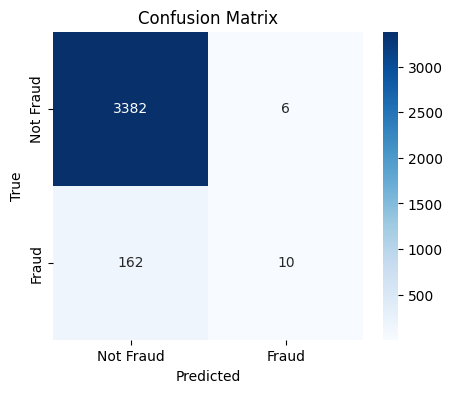

ROC AUC: 0.8186


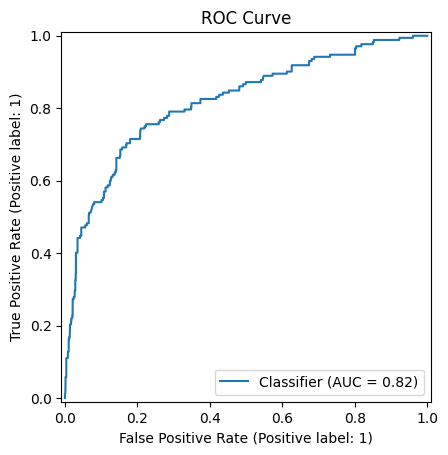

PR AUC: 0.2796


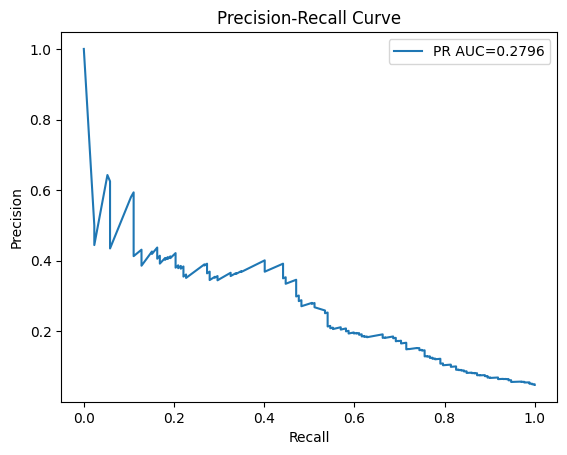

In [26]:
# %% Cell: Classification report, confusion matrix, ROC and PR AUC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Classification report (precision, recall, f1)
print("Classification report:")
print(classification_report(all_labels, all_preds, digits=4, target_names=["Not Fraud", "Fraud"]))

# 2) Confusion matrix (counts + heatmap)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 3) ROC AUC & ROC curve
try:
    roc_auc = roc_auc_score(all_labels, all_probs)
    print(f"ROC AUC: {roc_auc:.4f}")
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_predictions(all_labels, all_probs)
    plt.title("ROC Curve")
    plt.show()
except Exception as e:
    print("ROC AUC could not be computed:", e)

# 4) Precision-Recall and PR AUC
try:
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall, precision)
    print(f"PR AUC: {pr_auc:.4f}")
    plt.figure()
    plt.plot(recall, precision, label=f"PR AUC={pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()
except Exception as e:
    print("PR curve could not be computed:", e)

In [27]:
# %% Cell: Save per-sample predictions and overall metrics to disk
import json, pandas as pd

# Create DataFrame of per-sample results (if you want image paths, merge with val_df)
preds_df = pd.DataFrame({
    "true_label": all_labels,
    "pred": all_preds,
    "prob_fraud": all_probs
})
# If val_df contains filenames or other metadata, attach them:
if "_img_path" in val_df.columns and len(preds_df) == len(val_df):
    preds_df["_img_path"] = val_df["_img_path"].values

preds_csv = os.path.join(OUT_DIR, "val_predictions.csv")
preds_df.to_csv(preds_csv, index=False)
print("Saved per-sample predictions to:", preds_csv)

# Save summary metrics
metrics = {
    "n_val": int(len(all_labels)),
    "roc_auc": float(roc_auc) if 'roc_auc' in locals() else None,
    "pr_auc": float(pr_auc) if 'pr_auc' in locals() else None,
    "confusion_matrix": cm.tolist()
}
metrics_json = os.path.join(OUT_DIR, "metrics_summary.json")
with open(metrics_json, "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved summary metrics to:", metrics_json)

Saved per-sample predictions to: ./image_models/val_predictions.csv
Saved summary metrics to: ./image_models/metrics_summary.json
